<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/jjerry-k/tc_practice/blob/main/04_GRU.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/jjerry-k/tc_practice/blob/main/04_GRU.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Gated Recurrent Unit

In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("This notebook use [%s]."%(device))

PyTorch version:[1.7.0].
This notebook use [cuda:0].


# Set hyper-parameter

In [2]:
EPOCHS = 10
TIMESTEPS = 28
INPUT_FEATURES = 28
BATCH_SIZE = 256
LEARNING_RATE = 0.001

# Prepare dataset

In [3]:
# MNIST dataset
mnist_train = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

print("Preparing dataset done!")

Preparing dataset done!


# Defining Model

In [4]:
# our model
class Model(nn.Module):
    def __init__(self, input_size=28, hidden_size=256, num_layers=3, num_classes=10):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.gru(x, h0)
    
        out = self.linear(out[:, -1, :])
        return out

model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Calculate Parameters

In [5]:
total_params = 0
for param_name, param in model.named_parameters():
    if param.requires_grad:
        total_params += len(param.reshape(-1))
print(f"Number of Total Parameters: {total_params:,d}")

Number of Total Parameters: 1,011,722


# Define help function

In [6]:
def test_eval(model, data_iter, batch_size):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        total = 0
        correct = 0
        for batch_img, batch_lab in data_iter:
            X = batch_img.view(-1, 28, 28).to(device)
            Y = batch_lab.to(device)
            y_pred = model(X)
            _, predicted = torch.max(y_pred.data, 1)
            correct += (predicted == Y).sum().item()
            total += batch_img.size(0)
        val_acc = (100 * correct / total)
        model.train()
    return val_acc

# Train model 

In [7]:
# Training Phase
print_every = 1
print("Start training !")
# Training loop
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_img, batch_lab in train_iter:

        X = batch_img.view(-1, 28, 28).to(device)
        Y = batch_lab.to(device)
        
        # Inference & Calculate los
        y_pred = model.forward(X)
        loss = criterion(y_pred, Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_val_sum += loss
        
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        # accr_val = M.test(x_test, y_test, batch_size)
        loss_val_avg = loss_val_sum / len(train_iter)
        accr_val = test_eval(model, test_iter, BATCH_SIZE)
        print(f"epoch:[{epoch+1}/{EPOCHS}] cost:[{loss_val_avg:.3f}] test_accuracy:[{accr_val:.3f}]")
print("Training Done !")

Start training !
epoch:[1/10] cost:[0.507] test_accuracy:[95.260]
epoch:[2/10] cost:[0.113] test_accuracy:[97.870]
epoch:[3/10] cost:[0.069] test_accuracy:[98.490]
epoch:[4/10] cost:[0.048] test_accuracy:[98.730]
epoch:[5/10] cost:[0.038] test_accuracy:[98.760]
epoch:[6/10] cost:[0.031] test_accuracy:[98.820]
epoch:[7/10] cost:[0.027] test_accuracy:[98.820]
epoch:[8/10] cost:[0.022] test_accuracy:[98.810]
epoch:[9/10] cost:[0.020] test_accuracy:[99.040]
epoch:[10/10] cost:[0.019] test_accuracy:[99.070]
Training Done !


# Test model

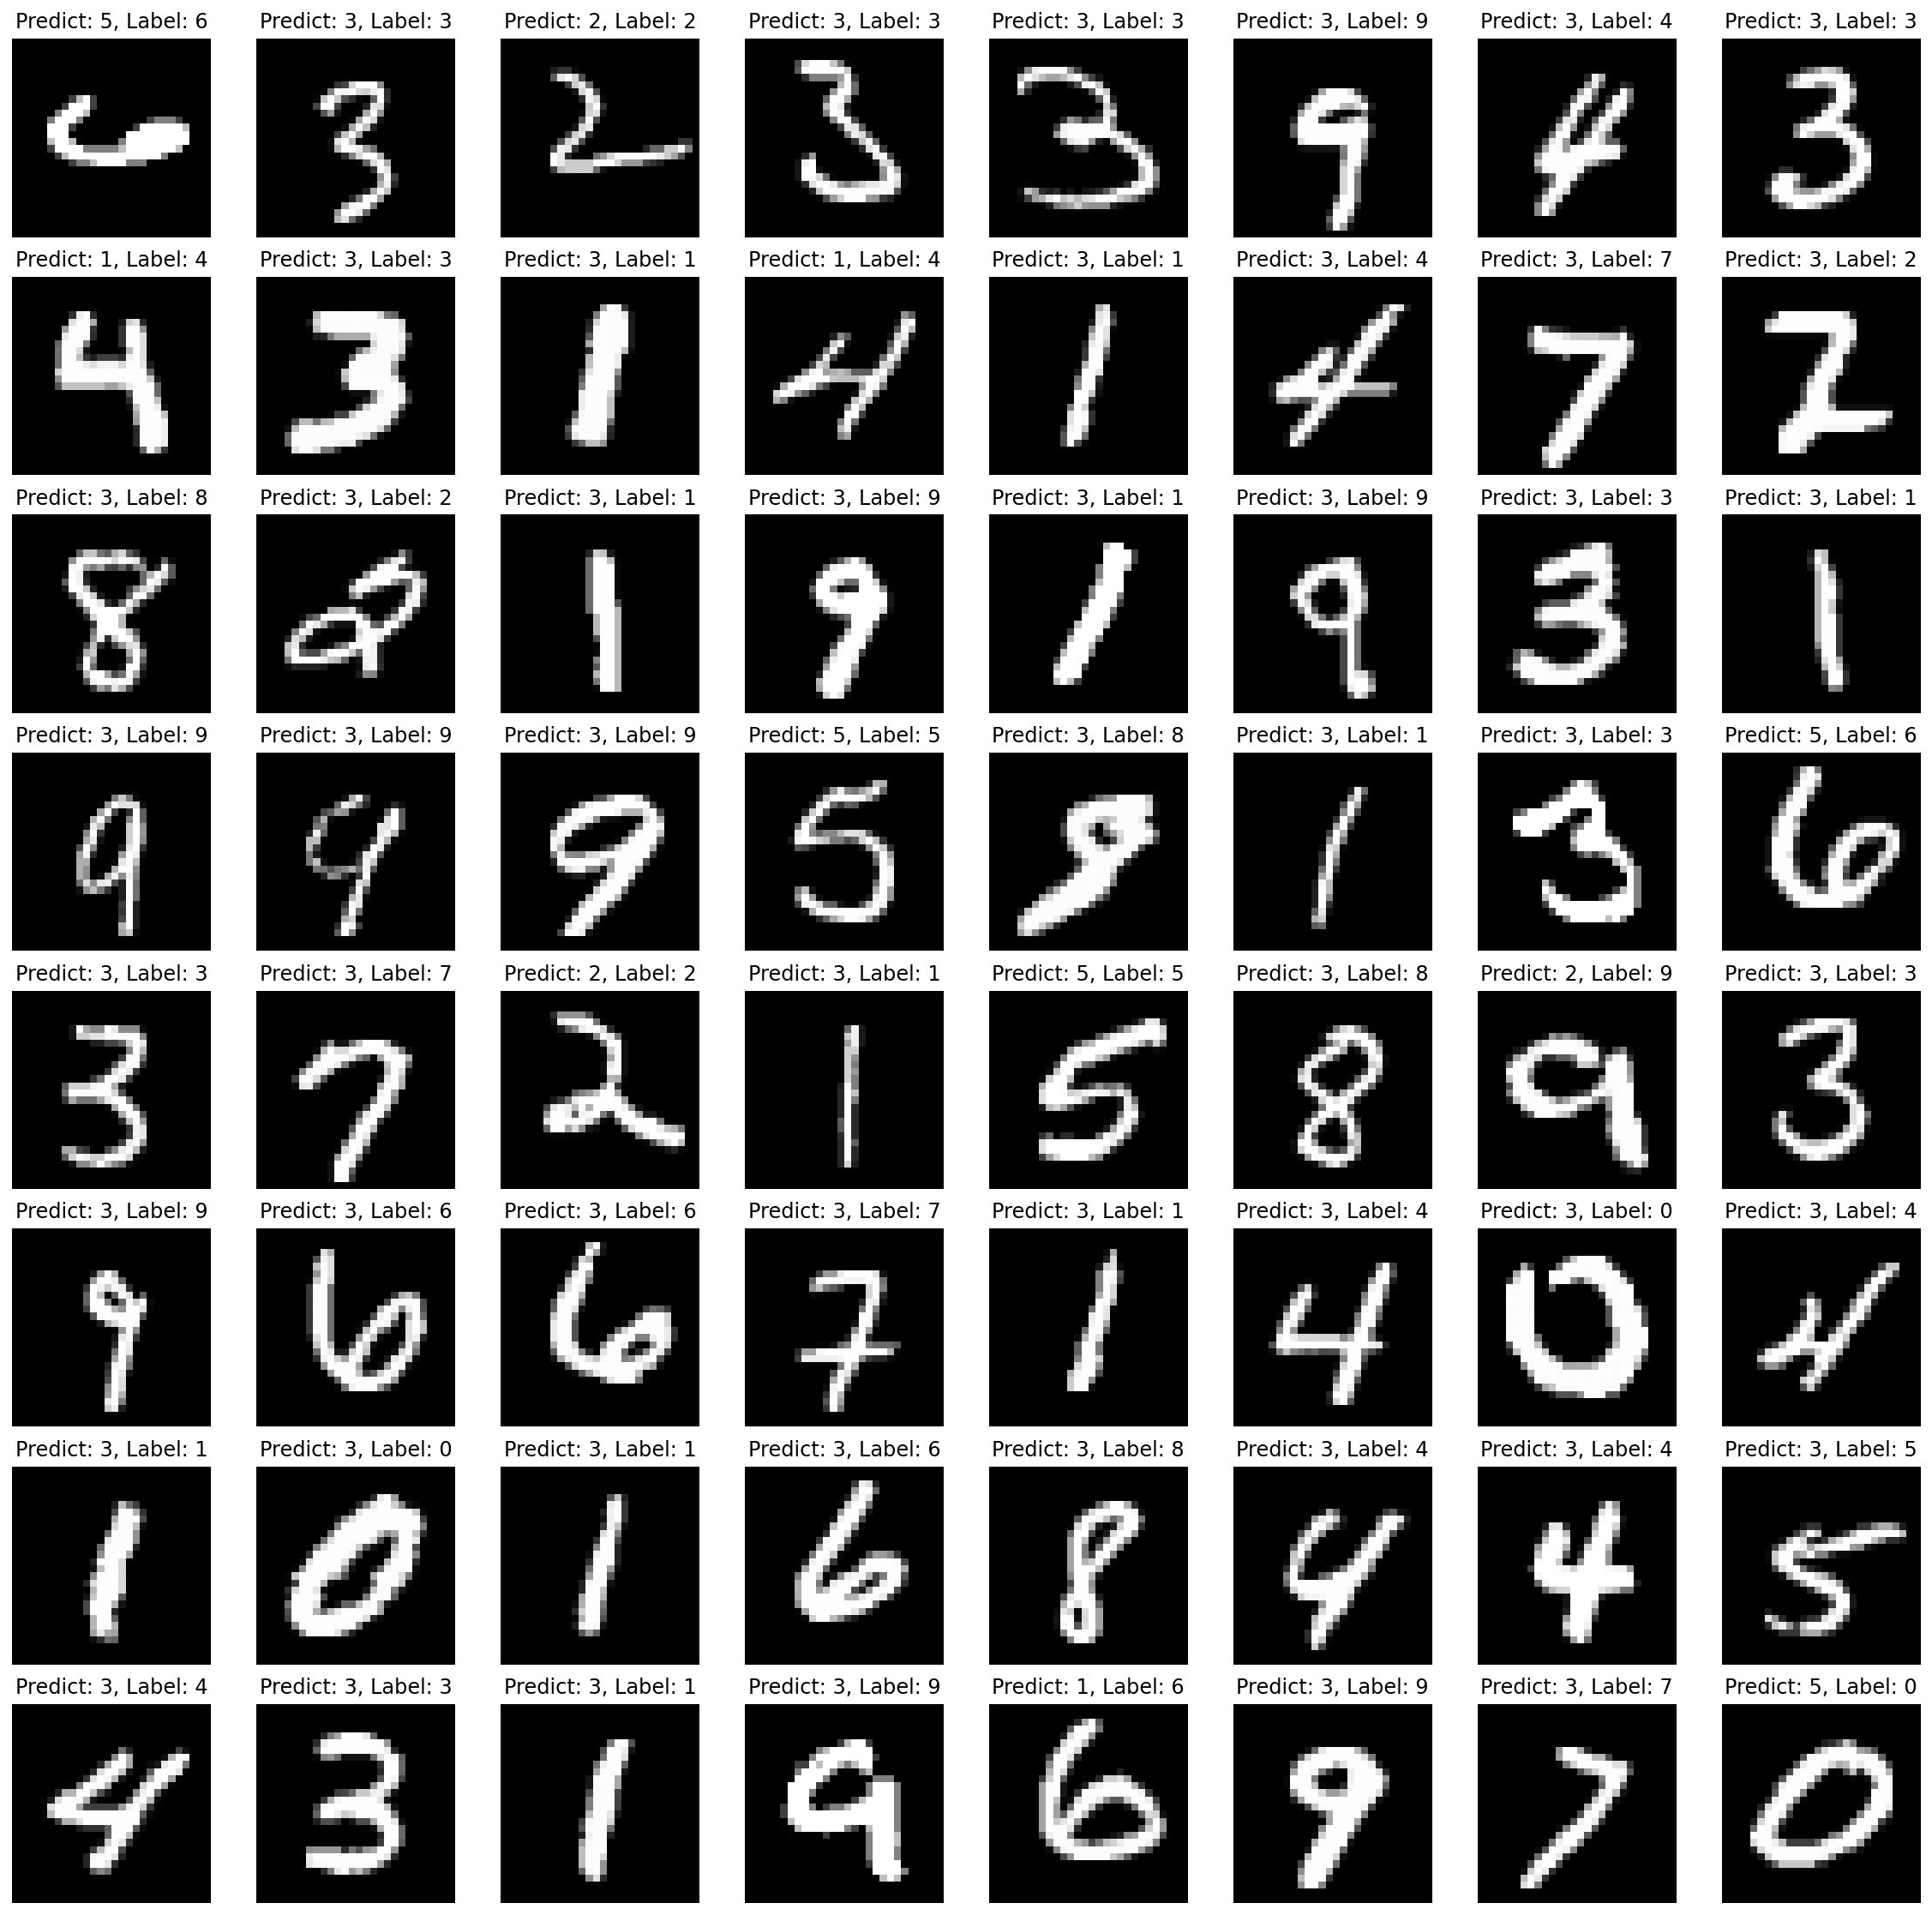

In [8]:
n_sample = 64
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]

with torch.no_grad():
    model.eval()
    y_pred = model.forward(test_x.view(-1, 28, 28).type(torch.float).to(device))
    model.train()

y_pred = y_pred.argmax(axis=1)

plt.figure(figsize=(20, 20))

for idx in range(n_sample):
    plt.subplot(8, 8, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title(f"Predict: {y_pred[idx]}, Label: {test_y[idx]}")

plt.show()